# Official source code of CLIPstyler

In [1]:
#@title Download Packages
import os
import sys
import matplotlib.pyplot as plt
clipstyler_dir = os.path.join("/content", "clipstyler")

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/paper11667/CLIPstyler/ $clipstyler_dir
sys.path.append(clipstyler_dir)

from PIL import Image
import numpy as np
import sys
import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

import StyleNet
import utils
import clip
import torch.nn.functional as F
from template import imagenet_templates

from PIL import Image
import PIL
from torchvision import utils as vutils
import argparse
from torchvision.transforms.functional import adjust_contrast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bes_0slj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bes_0slj
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [2]:
#@title Functions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG = models.vgg19(pretrained=True).features
VGG.to(device)

for parameter in VGG.parameters():
    parameter.requires_grad_(False)

def img_denormalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = image*std +mean
    return image

def img_normalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def clip_normalize(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image


def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)

    return loss_var_l2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 156MB/s]


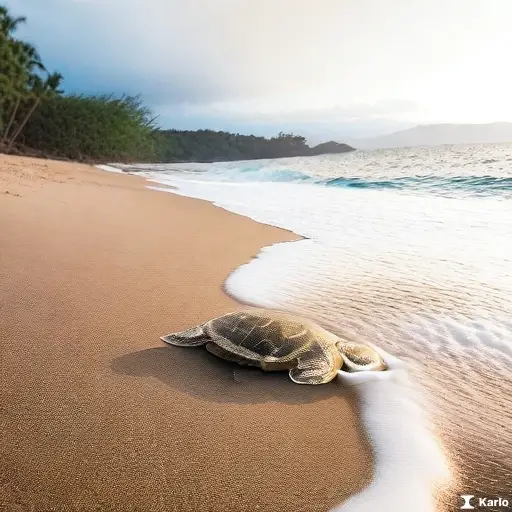

In [3]:
# @title 기본 제목 텍스트
# REST API 호출, 이미지 파일 처리에 필요한 라이브러리
import requests
import json
import urllib
from PIL import Image


# [내 애플리케이션] > [앱 키] 에서 확인한 REST API 키 값 입력
REST_API_KEY = 'fc187e839a690c98853212f6d41843d4'

# 이미지 생성하기 요청
def t2i(prompt, negative_prompt):
    r = requests.post(
        'https://api.kakaobrain.com/v2/inference/karlo/t2i',
        json = {
            "version": "v2.1",
            "prompt": prompt,
            "negative_prompt": negative_prompt,
            "height": 512,
            "width": 512
        },
        headers = {
            'Authorization': f'KakaoAK {REST_API_KEY}',
            'Content-Type': 'application/json'
        }
    )
    # 응답 JSON 형식으로 변환
    response = json.loads(r.content)
    return response

# 프롬프트에 사용할 제시어

prompt = "A picture of a turtle on a beach in Hawaii" # @param {type:"string"}

negative_prompt = ""

# 이미지 생성하기 REST API 호출
response = t2i(prompt, negative_prompt)

# 응답의 첫 번째 이미지 생성 결과 출력하기
result = Image.open(urllib.request.urlopen(response.get("images")[0].get("image")))

result.save("/content/clipstyler/outputs/result.png", "png")

result


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 150MiB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


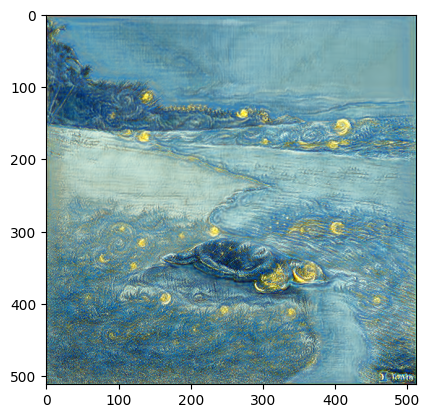

In [4]:
from IPython.display import display
from argparse import Namespace

source = "a Photo"

text = "Sketch with Gogh's The starry night" #@param {"type": "string"}
crop_size = 128 #@param {"type": "integer"}
image_dir =  "/content/clipstyler/outputs/result.png" #@param {type: "string"}


training_iterations = 100 #@param {type: "integer"}


training_args = {
    "lambda_tv": 2e-3,
    "lambda_patch": 9000,
    "lambda_dir": 500,
    "lambda_c": 150,
    "crop_size": 128,
    "num_crops":64,
    "img_height":512,
    "img_width":512,
    "max_step":training_iterations,
    "lr":5e-4,
    "thresh":0.7,
    "content_path":image_dir,
    "text":text
}

args = Namespace(**training_args)

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

content_path = args.content_path
content_image = utils.load_image2(content_path, img_height=args.img_height,img_width =args.img_width)

content_image = content_image.to(device)

content_features = utils.get_features(img_normalize(content_image), VGG)

target = content_image.clone().requires_grad_(True).to(device)

style_net = StyleNet.UNet()
style_net.to(device)

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3),keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(),m_cont[1].item(),m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
])

clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

prompt = args.text

source = "a Photo"


with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)

    # 텍스트의 특징 벡터 생성
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)

    # "a photo"에 대한 특징 벡터 생성
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)

    # 받은 이미지의 특징 벡터 생성
    source_features = clip_model.encode_image(clip_normalize(content_image,device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))


num_crops = args.num_crops
for epoch in range(0, steps+1):

    scheduler.step()
    target = style_net(content_image,use_sigmoid=True).to(device)
    target.requires_grad_(True)

    target_features = utils.get_features(img_normalize(target), VGG)

    content_loss = 0

    # 받은 이미지의 loss 계산
    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)


    loss_patch=0
    img_proc =[]

    # style을 적용한(만든) 이미지의 패치 생성 및 데이터 증강
    for n in range(num_crops):
        target_crop = cropper(target)
        target_crop = augment(target_crop)
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc,dim=0)
    img_aug = img_proc

    # clip을 사용하여 만든 이미지의 패치에 대한 특징 벡터 생성 -- text와 비교하기 위함
    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))

    # 만든 이미지의 패치에 대한 벡터와 받은 이미지의 벡터 차 계산
    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

    # "a photo"와 text의 벡터 차 계산 -- clip으로 텍스트를 만들면 "a photo"라는 문구가 붙어서
    # text_features에서 "a photo" 특징을 뺀 벡터를 기준으로 계산
    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)

    # "a photo" 기준으로 맞춰진 텍스트 벡터와 생성된 이미지의 벡터의 유사도를 text에 대한 loss로 정함
    loss_temp = (1- torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()

    # 만든 이미지의 특징 벡터 구함
    glob_features = clip_model.encode_image(clip_normalize(target,device))
    glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))

    # 만든 이미지의 특징 벡터와 받은 이미지의 특징 벡터 차
    glob_direction = (glob_features-source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

    # "a photo" 기준으로 맞춰진 텍스트 벡터와 받은 이미지의 벡터의 유사도를 text에 대한 loss로 정함
    loss_glob = (1- torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()

    # 부드러운 이미지 만들기 위함 -- 픽셀간 차이를 정규화 term에 넣은 것
    reg_tv = args.lambda_tv*get_image_prior_losses(target)

    total_loss = args.lambda_patch*loss_patch + content_weight * content_loss+ reg_tv+ args.lambda_dir*loss_glob
    total_loss_epoch.append(total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # if epoch % 20 == 0:
    #     print("After %d iters:" % epoch)
    #     print('Total loss: ', total_loss.item())
    #     print('Content loss: ', content_loss.item())
    #     print('patch loss: ', loss_patch.item())
    #     print('dir loss: ', loss_glob.item())
    #     print('TV loss: ', reg_tv.item())

output_image = target.clone()
output_image = torch.clamp(output_image,0,1)
output_image = adjust_contrast(output_image,1.5)
plt.imshow(utils.im_convert2(output_image))
plt.show()


